In [1]:
import pandas as pd
import numpy as np

from sys_dyn import Diagrama, Nivel, Flujo

%load_ext autoreload
%autoreload 2

In [2]:
def make_resumen(parametros, parametros_iniciales, resultado):
        
    resumen = pd.concat(
        [
            pd.DataFrame(parametros, index=["Reales"]),
            pd.DataFrame(convertir_parametros_lotka_volterra(parametros_iniciales), index=["Iniciales"]),
            pd.DataFrame(convertir_parametros_lotka_volterra(resultado.x), index=["Ajustados"])
        ],
        axis=0
    )

    # Set index name to 'Parámetros'
    resumen.index.name = "Parámetros"

    return resumen

# DEFINICIÓN DEL MODELO

In [3]:
# Parámetros del modelo
parametros = {
    "alpha": 0.1,    # Tasa de crecimiento de presas
    "beta": 0.002,   # Tasa de depredación
    "gamma": 0.2,    # Tasa de muerte de depredadores
    "delta": 0.0025  # Eficiencia de conversión de presas en depredadores
}

# Definir las funciones de los flujos según el modelo Lotka-Volterra
def tasa_crecimiento_presas(niveles, parametros, variables_exogenas):
    # La cantidad de presas aumenta de modo proporcional a su número
    return parametros["alpha"] * niveles["presa"].valor

def tasa_depredacion(niveles, parametros, variables_exogenas):
    # La cantidad de depredadores aumenta de modo proporcional a la cantidad de encuentros entre las dos especies
    return parametros["beta"] * niveles["presa"].valor * niveles["depredador"].valor

def tasa_crecimiento_depredadores(niveles, parametros, variables_exogenas):
    # La cantidad de depredadores aumenta de modo proporcional a la cantidad de presas encontradas
    return parametros["delta"] * niveles["presa"].valor * niveles["depredador"].valor

def tasa_muerte_depredadores(niveles, parametros, variables_exogenas):
    # La cantidad de depredadores disminuye de modo proporcional a su número
    return parametros["gamma"] * niveles["depredador"].valor

# Crear el diagrama de sistema
diagrama = Diagrama()

# Añadir los niveles para presas y depredadores
diagrama.agregar_elemento(Nivel("presa", valor_inicial=80))       # Población inicial de presas
diagrama.agregar_elemento(Nivel("depredador", valor_inicial=20))   # Población inicial de depredadores

# Añadir los flujos
diagrama.agregar_elemento(Flujo("crecimiento_presas", tasa_crecimiento_presas))
diagrama.agregar_elemento(Flujo("depredacion", tasa_depredacion))
diagrama.agregar_elemento(Flujo("crecimiento_depredadores", tasa_crecimiento_depredadores))
diagrama.agregar_elemento(Flujo("muerte_depredadores", tasa_muerte_depredadores))

# Definir conexiones entre niveles y flujos
conexiones = {
    "flujos_entrantes": {
        "presa": ["crecimiento_presas"],
        "depredador": ["crecimiento_depredadores"]
    },
    "flujos_salientes": {
        "presa": ["depredacion"],
        "depredador": ["muerte_depredadores"]
    }
}

diagrama.agregar_conexiones(conexiones)

diagrama.set_delta_t(0.1)


# SIMULACIÓN

In [4]:
# Ejecutar la simulación
tiempo_total = 100
# parametros.update(conexiones)  # Añadir conexiones a los parámetros
diagrama.simular(tiempo_total=tiempo_total, parametros=parametros)

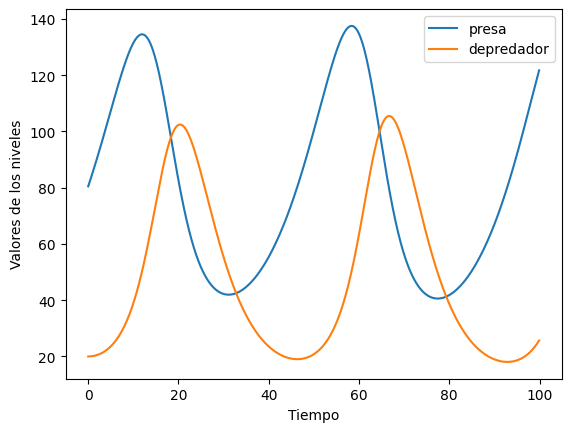

In [5]:
# Graficar los resultados
diagrama.graficar()

# AJUSTE DE PARÁMETROS

In [6]:
datos_observados = diagrama.obtener_resultados()

# Add noise to the data
# np.random.seed(0)
# for nivel, observados in datos_observados.items():
#     datos_observados[nivel] = [max(0, obs + np.random.normal(0, 10)) for obs in observados]

# Crea una secuencia de 0 a tiempo_total con pasos de delt_t
tiempos = np.arange(0, tiempo_total, diagrama.delta_t)

# Modifica las listas en el diccionario de datos_observados de manera que cada elemento sea una tupla (tiempo, valor)
datos_observados = {nivel: list(zip(tiempos, valores)) for nivel, valores in datos_observados.items()}

# REALES: alpha=0.1, beta=0.002, gamma=0.2, delta=0.0025

# Parámetros iniciales para ajustar (alpha, beta, gamma, delta)
parametros_iniciales = [0.5, 0.005, 0.5, 0.005]

# Función de conversión específica del modelo Lotka-Volterra
def convertir_parametros_lotka_volterra(parametros_array):
    return {
        "alpha": parametros_array[0],
        "beta": parametros_array[1],
        "gamma": parametros_array[2],
        "delta": parametros_array[3],
    }

# Limites para los parámetros (alpha, beta, gamma, delta)
limites = [(0, 1), (0.001, 0.01), (0, 1), (0.001, 0.01)]

# Llamada a ajustar_parametros con el modelo específico
diagrama.set_delta_t(0.01)
resultado = diagrama.ajustar_parametros(datos_observados, parametros_iniciales, convertir_parametros_lotka_volterra, limites=limites, error_metric='nrmse')

# Informa de los detalles de los resultados de la optimización
print(f"Success: {resultado.success} - {resultado.message} in {resultado.nit} iteraciones (error final: {resultado.fun})")

Ajustando parámetros con método: L-BFGS-B y métrica de error: nrmse
Success: True - CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH in 28 iteraciones (error final: 0.5228288350673556)


In [7]:
make_resumen(parametros, parametros_iniciales, resultado)

,alpha,beta,gamma,delta
Parámetros,,,,
Reales,0.100000,0.002000,0.200000,0.0025
Iniciales,0.500000,0.005000,0.500000,0.0050
Ajustados,0.144634,0.004342,0.803642,0.0100


In [8]:
# Llamada a ajustar_parametros con el modelo específico
resultado = diagrama.ajustar_parametros(datos_observados, parametros_iniciales, convertir_parametros_lotka_volterra, method='Nelder-Mead', limites=limites, error_metric='mse_escalado')

# Informa de los detalles de los resultados de la optimización
print(f"Success: {resultado.success} - {resultado.message} in {resultado.nit} iteraciones (error final: {resultado.fun})")

Ajustando parámetros con método: Nelder-Mead y métrica de error: mse_escalado
Success: True - Optimization terminated successfully. in 174 iteraciones (error final: 1.5697574805491443)


In [9]:
make_resumen(parametros, parametros_iniciales, resultado)

,alpha,beta,gamma,delta
Parámetros,,,,
Reales,0.100000,0.002000,0.200000,0.0025
Iniciales,0.500000,0.005000,0.500000,0.0050
Ajustados,0.144609,0.004341,0.803434,0.0100


In [10]:
# Llamada a ajustar_parametros con el modelo específico
resultado = diagrama.ajustar_parametros(datos_observados, parametros_iniciales, convertir_parametros_lotka_volterra, method='Powell', limites=limites, error_metric='mape')

# Informa de los detalles de los resultados de la optimización
print(f"Success: {resultado.success} - {resultado.message} in {resultado.nit} iteraciones (error final: {resultado.fun})")

Ajustando parámetros con método: Powell y métrica de error: mape
Success: True - Optimization terminated successfully. in 4 iteraciones (error final: 0.6504336610981758)


In [11]:
make_resumen(parametros, parametros_iniciales, resultado)

,alpha,beta,gamma,delta
Parámetros,,,,
Reales,0.100000,0.002000,0.200000,0.002500
Iniciales,0.500000,0.005000,0.500000,0.005000
Ajustados,0.117172,0.004934,0.353875,0.005089
